<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Jinli/Big_Data_Milk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [1]:
# To download and update the necessary requirements, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/ma

In [2]:
# To initialize Apache Spark, run this cell
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Loading the data into a DF


In [3]:
!ls 'gdrive/MyDrive/'

'App ontwikkeling.gdoc'
 Big_Data_Groupwork_Project
 Bijbaan
'Bus 356 Connexion.gdoc'
'Citygames Delft:.gdoc'
'Colab Notebooks'
'Conneccie 2018-2019'
 CV
'DIPP meetings notebook.gdoc'
'edX courses, Udemy and more online courses.gdoc'
'(EUR) Erasmus Universiteit'
'Experiment 1 FP&D.gsheet'
'Experiment 1 FP&D.xlsx'
'Food Hazards Case Study Beer-Can Chicken.gdoc'
 GOT.gdoc
 Group39_Assignment2.gdoc
 Group39_Assignment4.gdoc
 IMG_5467.JPG
 IMG_5468.JPG
 IMG_5469.JPG
 IMG_5470.JPG
 IMG_5471.JPG
 INF33806
'Nooit meer vergeten'
'Online Examination Test 10 april 2020.gdoc'
'Quality Systems Operations Definitions sheet.gdoc'
 Roblox
'safari leeslijst.gdoc'
 Thee.gdoc
'Thymos evaluation survey 6 april 2020.gdoc'
 Vossius
'(VU) Vrije Universiteit'
 Wageningen
' Wild, Janniek de; Witsenboer, Jin-Li Food P&D practical 1, 2, 3 .gdoc'
'WSR ARGO ALV pagina.gdoc'


In [ ]:
# WRONGG

"""
# Read the data from the csv file


#milk_rdd = spark.read.csv('gdrive/MyDrive/Big_Data_Groupwork/ff_dairy_v1.csv', header=True, inferSchema = True)
milk_data = spark.read.csv('/content/gdrive/MyDrive/Big_Data_Groupwork_Project/Big_Data_Groupwork/ff_dairy_v1.csv', header=True, inferSchema = True)

# work from dataframes is sufficient
"""

In [ ]:
milk_data.show(5)

+----------+----+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----------

Question 1: 

Which combination of nutrients is the best predictor for the fat yield (milk yield * fat %) ?

In [ ]:

"""
# select the yield column and fat% column

subDF_null = milk_data.select('Milk yield (kg)', 'Fat%')
subDF_null.show(5)

subDF = subDF_null.dropna()
yield_col = subDF.select('Milk yield (kg)')
fat_pc_col = subDF.select('Fat%')

subDF.show(5)

fat_yield = list(map(lambda x, y : x*y, yield_col, fat_pc_col))

# or 

data = milk_data.toPandas()

milk_yield = data.loc[:, "Milk yield (kg)"]
fat = data.loc[:, "Fat%"]
total_fat = milk_yield * fat
"""

+---------------+----+
|Milk yield (kg)|Fat%|
+---------------+----+
|          40.47|3.55|
|          38.29|null|
|          39.28|null|
|          38.16|null|
|          44.06|null|
+---------------+----+
only showing top 5 rows

+---------------+----+
|Milk yield (kg)|Fat%|
+---------------+----+
|          40.47|3.55|
|          40.12|3.49|
|          42.09|3.33|
|          36.26|3.45|
|          31.12|3.89|
+---------------+----+
only showing top 5 rows



**Import plot libraries**

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from pyspark import SparkFiles

from pyspark.sql import types
from pyspark.sql import functions as psf
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.regression import LinearRegression

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# imports used for removal of NULL values

from pyspark.sql import Window
from pyspark.sql.functions import last
import sys


# software

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Select the variables**

Read the file and convert to both Spark and Pandas dataframe

In [5]:
# Downloading the preprocessed datafile from the github in raw format
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
fileName = url.split('/')[-1] #The filename is everything after "main/"

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(url)
milk_url = spark.read.csv(SparkFiles.get(fileName), header=True)

# Also load the data to a pandas table, just in case we need it for testing.
milk_url_pd=pd.read_csv(url, encoding='latin1')

Add an extra column for the total fat (fat yield)

In [6]:
# extra column total fat (fat yield)

milk_url2 = milk_url.withColumn('total_fat', milk_url['Milk yield (kg)'] * milk_url['Fat%'])
milk_url_pd2 = milk_url2.toPandas()

Select a subset with nutrients

In [7]:
# crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg, WDS, SPK, TPK, SPE, TPE, +I, Wi, GP 
# intestines: nXP, RNB, MELK, NEL, WDE, EKB

nutrients_selected = milk_url.select(['Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
                             'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']).dropna(subset = "Fat%")
nutrients = nutrients_selected.select([nutrients_selected[col].cast('float') for col in nutrients_selected.columns])

nutrients_pd = nutrients.select('*').toPandas()
nutrients_pd[['Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
              'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']] = nutrients_pd[['Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
              'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']].apply(pd.to_numeric)

# don't forget to import pandas as pd before running apply(pd.to_numeric)

Fix the datatype

In [9]:
from pyspark.sql import functions as F
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, F.col(colName).cast(dataType))

# Preparing Lists with the colum names and which type they need to be
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'total_fat']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_url3 = milk_url2

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_url3 = fixType(milk_url3, colName, "double")
for colName in intColumns:
  milk_url3 = fixType(milk_url3, colName, "int")
milk_url3 = milk_url3.withColumn("Date", F.col("Date").cast("date"))



Fill in NULL values and remove columns with too much NULL values

In [18]:
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_url3.columns:
  filled_column = last(milk_url3[column], ignorenulls=True).over(window)
  milk_url4 = milk_url3.withColumn(column, filled_column)

milk_data = milk_url4

milk_data_pd = milk_data.toPandas()



# Drop empty values (otherwise it can't work with the data)
#milk_rdd3 = milk_data.dropna(how='any', subset=inputColNames+[labelColName])


KeyboardInterrupt: ignored

**Variable names and datatypes**

milk_data = Spark dataframe 
 - from spark.read_csv()
 - pyspark.sql.dataframe.DataFrame
 - wrong columnnames AVG temp, Max temp and I (/day)


**correct**

milk_url = Spark dataframe 
 - from spark.read_csv()
 - pyspark.sql.dataframe.DataFrame
 - correct AVG temp, max temp and I (/day)

milk_url_pd = Pandas dataframe
 - from toPandas()
 - pandas.core.frame.DataFrame
 - correct AVG temp, max temp and I (/day)

milk_url2 = Spark dataframe
 - extra 'total_fat' column added -> last column is 'total' fat
 - can be converted to pandas using toPandas()

milk_url_pd2 = Pandas dataframe 
 - extra 'total_fat' column included -> last column is 'total' fat
 - derived from milk_data2

nutrients = Spark dataframe
 - selected the nutrients (Crude fiber and Ca etc)
 - pyspark.sql.dataframe.DataFrame

nutrients_pd = Pandas dataframe
 - convert nutrients to pandas 
 - also used: apply(pd.to_numeric) so expect numeric values ipv strings

milk_url3 = Spark dataframe
 - fixed datatype for all variables + extra total_fat column

milk_data = Spark dataframe
 - null values corrected 

milk_data_pd = Pandas dataframe
 - converted milk_data to pandas

In [15]:
milk_data.show(5)



+----------+----+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----------

# **Visualization**

**Scatterplots**

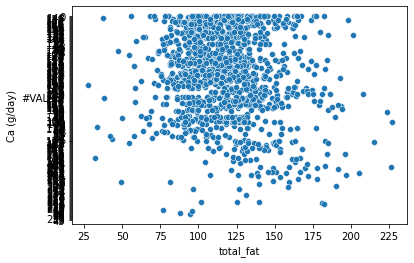

In [ ]:
sns.scatterplot(x='total_fat', y='Ca (g/day)', data=milk_url_pd2)


**Linear regression models**

werkt niet: zie verderop


In [ ]:
# werkt niet

corr_mat = data_pandas.corr(method='pearson')
#plt.subplots(figsize=(30,30))

corr_mat.loc[:, "Fat%"]

#sns.heatmap(corr_mat, cmap='coolwarm')

assembler = VectorAssembler(
    inputCols = [col for col in nutrients.columns if col != "Fat%"],
    outputCol = "features")
output = assembler.transform(nutrients).select('features', 'Fat%')

test_data, train_data = output.randomSplit([0.8, 0.2], 0)
lr = LinearRegression(featuresCol = 'features', labelCol='Fat%')
lrModel = lr.fit(train_data)

**Barplot**

In [ ]:
df_corr = nutrients.corr('Fat%', 'Crude fiber (g/day)')
df_corr
#df_corr[['cor_fiber']].plot(kind='hist')

0.05765395562892454

In [ ]:
print(type(total_fat))
print('hello')
print(type(cr_fiber_col))


"""
lines = plt.xcorr(total_fat, cr_fiber_col)

plot.title('Hypothetical Data: Angle of collision vs Energy lost')

plot.xlabel('Angle of collision')

plot.ylabel('Energy lost')    

plot.grid(True)

plot.axhline(0, color='red', lw=2)

plot.show()
"""

<class 'pandas.core.series.Series'>
hello
<class 'pandas.core.series.Series'>


"\nlines = plt.xcorr(total_fat, cr_fiber_col)\n\nplot.title('Hypothetical Data: Angle of collision vs Energy lost')\n\nplot.xlabel('Angle of collision')\n\nplot.ylabel('Energy lost')    \n\nplot.grid(True)\n\nplot.axhline(0, color='red', lw=2)\n\nplot.show()\n"

In [ ]:
# library & dataset
import seaborn as sns
df = sns.load_dataset('iris')
import matplotlib.pyplot as plt
 
# Basic correlogram
#sns.pairplot(nutrients_pd)


**Correlation Matrix**

Correlation matrix for the nutrients

In [16]:
#
# create column dataframe without NULL values -> returns a series object
cr_fiberss = milk_data_pd.loc[:,'Crude fiber (g/day)']
cr_fiber_col2 = milk_data_pd.loc[:,'Crude fiber (g/day)']
sugar_col2 = milk_data_pd.loc[:,'Sugar (g/day)']
cr_protein_col2 = milk_data_pd.loc[:,'Crude protein (g/day)']
cr_fat_col2 = milk_data_pd.loc[:,'Crude fat (g/day)']
starch_col2 = milk_data_pd.loc[:,'Starch (g/day)']

ca_col2 = milk_data_pd.loc[:,'Ca (g/day)']
p_col2 = milk_data_pd.loc[:,'P (g/day)']
na_col2 = milk_data_pd.loc[:,'Na (g/day)']
cl_col2 = milk_data_pd.loc[:,'Cl (g/day)']
k_col2 = milk_data_pd.loc[:,'K (g/day)']
mg_col2 = milk_data_pd.loc[:,'Mg (g/day)']

fat_col2 = milk_data_pd.loc[:,'Fat%']
milk_yield_col2 = milk_data_pd.loc[:,'Milk yield (kg)']
fat_yield_col2 = milk_data_pd.loc[:,'total_fat']

# create a list/array from the columns -> returns a list/array
cr_fiber_array = cr_fiber_col2.values
sugar_array = sugar_col2.values
cr_protein_array = cr_protein_col2.values
cr_fat_array = cr_fat_col2.values
starch_array = starch_col2.values

ca_array = ca_col2.values
p_array = p_col2.values
na_array = na_col2.values
cl_array = cl_col2.values
k_array = k_col2.values
mg_array = mg_col2.values

fat_array = fat_col2.values
milk_yield_array = milk_yield_col2.values
fat_yield_array = fat_yield_col2.values

# create a dictionary from the arrays

data_dict = {'cr_fiber': cr_fiber_array, 
             'sugar':sugar_array,
             'cr_protein':cr_protein_array,
             'cr_fat':cr_fat_array,
             'starch':starch_array,
             'ca':ca_array,
             'p':p_array,
             'na':na_array,
             'cl':cl_array,
             'k':k_array,
             'mg':mg_array,
             'fat':fat_array,
             'milk_yield':milk_yield_array,
             'fat_yield':fat_yield_array}

# create a panda dataframe from the dictionary

nutrients_pd_df = pd.DataFrame(data_dict, columns=['cr_fiber', 'sugar', 'cr_protein', 'cr_fat', 'starch', 'ca', 'p', 'na', 'cl', 'k', 'mg', 'fat', 'milk_yield', 'fat_yield'])

#print(nutrients_pd_df.dtypes) 
# -> test if all column datatypes are float64


# create a correlation matrix

corrMatrix = nutrients_pd_df.corr()
print(corrMatrix)

# plot the correlation matrix

sns.heatmap(corrMatrix, annot=True)
plt.show()

NameError: ignored

Correlation matrix for the conditions

              total_intake     water  ...  milk_yield  fat_yield
total_intake      1.000000  0.466425  ...    0.382634   0.439671
water             0.466425  1.000000  ...    0.494031   0.417108
conc_intake       0.482197  0.526487  ...    0.534643   0.545561
weight            0.396282  0.214633  ...    0.099203   0.280584
avgtemp          -0.074519  0.199163  ...   -0.017924  -0.048398
maxtemp          -0.067644  0.191300  ...   -0.001245   0.070909
milk_pre          0.489364  0.580407  ...    0.679524   0.560106
fat_pre           0.106662  0.036010  ...   -0.152583   0.314921
fat              -0.009679 -0.097577  ...   -0.310436   0.321649
milk_yield        0.382634  0.494031  ...    1.000000   0.787046
fat_yield         0.439671  0.417108  ...    0.787046   1.000000

[11 rows x 11 columns]


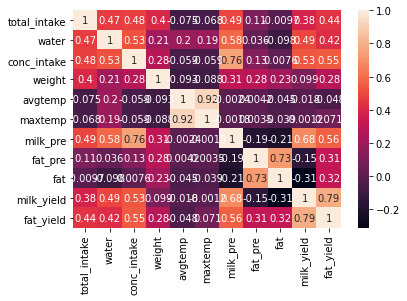

In [ ]:
#Intake basal ration (kg dm), Intake total ration (kg dm), Water intake (kg), Concentrate intake (kg), Weight (kg), Avg Temperature (degC), Max temperature (degC)
# Milk yield prepreriod (kg), Fat% preperiod
# create column dataframe = -> returns a series object
total_intake_col2 = milk_data_pd.loc[:,'Intake total ration (kg dm)']
water_col2 = milk_data_pd.loc[:,'Water intake (kg)']
conc_intake_col2 = milk_data_pd.loc[:,'Concentrate intake (kg)']
weight_col2 = milk_data_pd.loc[:,'Weight (kg)']
avgtemp_col2 = milk_data_pd.loc[:,'Avg Temperature (degC)']
maxtemp_col2 = milk_data_pd.loc[:,'Max temperature (degC)']

milk_pre_col2 = milk_data_pd.loc[:,'Milk yield prepreriod (kg)']
fat_pre_col2 = milk_data_pd.loc[:,'Fat% preperiod']

fat_col2 = milk_data_pd.loc[:,'Fat%']
milk_yield_col2 = milk_data_pd.loc[:,'Milk yield (kg)']
fat_yield_col2 = milk_data_pd.loc[:,'total_fat']

# create a list/array from the columns -> returns a list/array
total_intake_array = total_intake_col2.values
water_array = water_col2.values
conc_intake_array = conc_intake_col2.values
weight_array = weight_col2.values
avgtemp_array = avgtemp_col2.values
maxtemp_array = maxtemp_col2.values

milk_pre_array = milk_pre_col2.values
fat_pre_array = fat_pre_col2.values

fat_array = fat_col2.values
milk_yield_array = milk_yield_col2.values
fat_yield_array = fat_yield_col2.values

# create a dictionary from the arrays

data_dict = {'total_intake': total_intake_array, 
             'water':water_array,
             'conc_intake':conc_intake_array,
             'weight':weight_array,
             'avgtemp':avgtemp_array,
             'maxtemp':maxtemp_array,
             'milk_pre':milk_pre_array,
             'fat_pre':fat_pre_array,
             'fat':fat_array ,
             'milk_yield':milk_yield_array,
             'fat_yield':fat_yield_array,
             }

# create a panda dataframe from the dictionary

nutrients_pd_df = pd.DataFrame(data_dict, columns=['total_intake', 'water', 'conc_intake', 'weight', 'avgtemp', 'maxtemp', 'milk_pre', 'fat_pre', 'fat', 'milk_yield', 'fat_yield'])

#print(nutrients_pd_df.dtypes) 
# -> test if all column datatypes are float64


# create a correlation matrix

corrMatrix = nutrients_pd_df.corr()
print(corrMatrix)

# plot the correlation matrix

sns.heatmap(corrMatrix, annot=True)
plt.show()

**Line plots**

In [ ]:
cr_fiber_col = data_pandas.loc[:,'Crude fiber (g/day)'].dropna()

yield_fiber = milk_rdd.select('Milk yield (kg)', 'Fat%', 'Crude fiber (g/day)').dropna()
# nr of rows of all three columns = 1337

cr_fiber_col2 = yield_fiber.select('Crude fiber (g/day)')
yield_fiber_total = yield_fiber.withColumn('total_fat', milk_rdd['Milk yield (kg)'] * milk_rdd['Fat%'])
# add an extra column fat yield
fat_yield2 = yield_fiber_total.select('total_fat')

type(cr_fiber_col) # pandas series
type(fat_yield2) # dataframe



NameError: ignored

**Plotting sample of dataset against 1 column**

In [ ]:
## Copy of setting the correct columns to allow easier plotting

### CHANGE inputColNames (list of x) AND LabelColName (y) TO CREATE THE
### DESIRED PLOTS. # ONLY 10 x VALUES CAN BE ENTERED AT A TIME

inputColNames = ['Ca (g/day)' ]
#inputColNames = doubleColumns[0:10]



#labelColName = "Milk yield (kg)"
labelColName = 'Sugar (g/day)'
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

# Drop empty values (otherwise it can't work with the data)
# WE MIGHT NEED TO FIND AN ALTERNATIVE TO DROPPING ANY ROW WITH BLANKS!
# CURRENTLY EXPERIMENTING WITH NOT DROPPING NA FOR THE PLOTTING
#milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])
milk_subset = milk_data.select(inputColNames+[labelColName])

In [ ]:
type(inputColNames)
milk_sample.show(5)

+----------+-------------+
|Ca (g/day)|Sugar (g/day)|
+----------+-------------+
|         0|            0|
|       148|         1100|
|       132|          980|
|       148|         1094|
|       160|         1190|
+----------+-------------+
only showing top 5 rows



<Figure size 720x720 with 0 Axes>

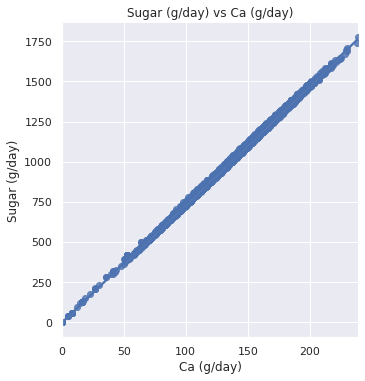

In [ ]:
## Plotting the columns versus the labelcolumn to get inital idea of linear regression

### Trying to plot more than 10 plots at the same time results in empty plots ###

milk_sample = milk_subset.select(inputColNames+[labelColName]).sample(False,0.5)
#print(milk_rdd3_sample)
sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)

In [ ]:
# calculate VIF


#df_vif = df[['Ca (g/day)', 'P (g/day)', 'Na (g/day)' ]].dropna()

#df[['annual_inc','loan_amnt', 'funded_amnt','annual_inc','dti']].dropna()

# str_to_remove = [r'(', r')'] 
# columns_list = [allColumns, doubleColumns, intColumns, stringColumn]
# allColumnsTemp = [col for col in allColumns]
# for column in columns_list:
#   for i in range(len(column)):
#     for substring in str_to_remove:
#       column[i] = column[i].replace(substring, '').strip()
#       column[i] = column[i].replace('/', ' ').strip()

# for col1, col2 in zip(allColumnsTemp, allColumns):
#   milk_data = milk_rdd.withColumnRenamed(col1, col2)

#%%capture
#gather features
milk_data_pd = milk_data.toPandas()
milk_selection = milk_data_pd[['Ca (g/day)', 'Sugar (g/day)']]
features = "+".join(milk_data.columns)


# get y and X dataframes based on this regression:
y, X = dmatrices('Sugar (g/day) ~' + features, milk_pd, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

SyntaxError: ignored

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('Sugar (g/day) ~ Ca (g/day)', data=milk_data_pd, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

PatsyError: ignored